Philippe Joly 27-09-24

@Author  : Linbo<linbo.me>

@Version: 1.0    25/10/2014

This is the implementation of the Zhang-Suen Thinning Algorithm for skeletonization.

In [356]:
import matplotlib.pyplot as plt
import numpy as np

import skimage.io as io
from skimage.filters import threshold_otsu, sobel
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.segmentation import watershed
import cv2
from scipy import ndimage

# Knot and Rope Skeletonization

In [357]:
i= 4

## Import Pictures and Binarization

### Otsu Segmentation

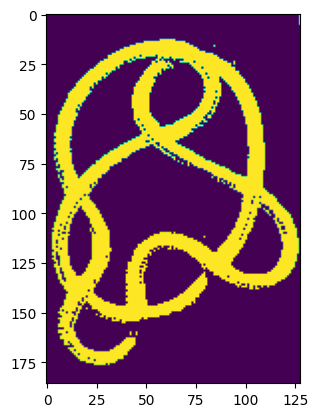

In [358]:
img_Original =  io.imread(f'./examples/{i}_knot.png')[...,:3]      # Gray image, rgb images need pre-conversion
img_gray = rgb2gray(img_Original)

"Convert gray images to binary images using Otsu's method"
Otsu_Threshold = threshold_otsu(img_gray) 
t = Otsu_Threshold  
BW_Original = img_gray > t
plt.imshow(BW_Original)

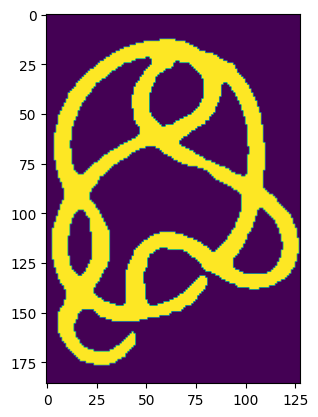

In [359]:
sz = 3
kernel = np.ones((sz,sz))
closing = ndimage.binary_closing(BW_Original, structure=kernel)

# Apply morphological opening
opening = ndimage.binary_opening(closing, structure=kernel)

# Apply median filter
result = ndimage.median_filter(opening, size=sz)

plt.imshow(result)

### Region-Based Segmentation

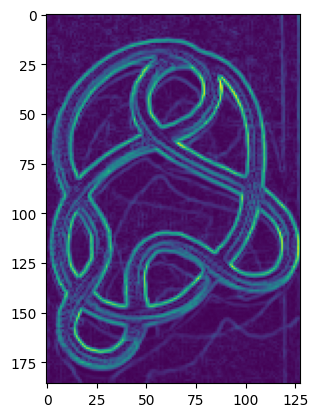

In [360]:
elevation_map = sobel(img_gray)
plt.imshow(elevation_map)

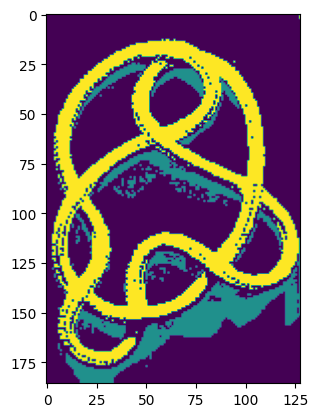

In [361]:
markers = np.zeros_like(img_gray)
markers[img_gray<30/255]=1
markers[img_gray>150/255]=2
markers = markers.astype(np.int32)
plt.imshow(markers)
# print(img_gray.max())

In [362]:
elevation_map.shape

(186, 128)

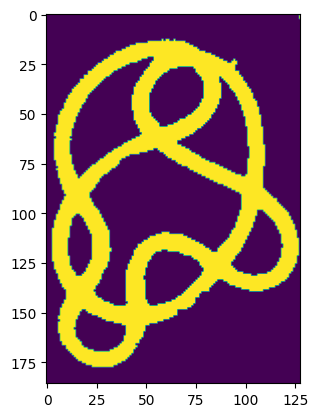

In [363]:
segmant = watershed(elevation_map, markers)-1
plt.imshow(segmant)

## Zhang's Algorithm 

In [364]:
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned

## Results

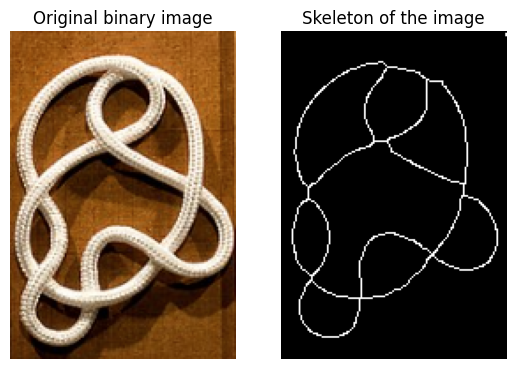

In [365]:
BW_Skeleton = zhangSuen(segmant)
# BW_Skeleton = result
"Display the results"
fig, ax = plt.subplots(1, 2)
ax1, ax2 = ax.ravel()
ax1.imshow(img_Original)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('Skeleton of the image')
ax2.axis('off')
plt.show()